I initially wanted to do a project where I would predict what state a college is in based on its features. After seeing scatter matrixes, and seeing each state's means/medians/stds and other descriptive statistics on each feature, I realized it's an impossible task. 
`pd.plotting.scatter_matrix(collegeInfo[['Overall annual cost of attendance','% Black','SAT Math']]) #saw the feature matrix, realized distance from home has no correlation with anything. Removed it altogether
collegeInfo.groupby('State').mean()`

Each state's college metrics are ridiculously similar, and there's virtually no way of telling what state a college is in based on its SAT, demographis, cost of attendance, etc. These features/characteristics barely differ from state to state, so it was a pretty stupid idea to begin with. The only feature that would actually be helpful in this project is the distance from home, but that would be a stupid model to make. "Oh this college is 50 miles away so it's either in Illinois, Indiana, or Wisconsin. I will guess it's Indiana with a 40% probability because it had a slightly higher percentage of whites than an average Illinois/Wisconsin college." Or, you know, something similar :) So as a result, I came up with new project idea, and it ended up being this.

In [11]:
#attributions, explanations, etc. are in the College search IL notebook
#get all the data from the CollegeScorecard API
import requests
import math
import numpy as np
from IPython.display import display
import pandas as pd

key = "nyiNevdtUIEMrkovbB6bYPDsdi8V4rRBSEzXtN9s"
url_base = "https://api.data.gov/ed/collegescorecard/v1/schools/"
fields = ','.join([
    "school.name",
    "latest.admissions.admission_rate.overall","latest.admissions.sat_scores.midpoint.critical_reading","latest.admissions.sat_scores.midpoint.writing","latest.admissions.sat_scores.midpoint.math","latest.admissions.act_scores.midpoint.cumulative",
    "latest.academics.program_percentage.computer","latest.academics.program_percentage.mathematics",
    "latest.student.demographics.median_hh_income","latest.student.size","latest.student.demographics.female_share","latest.student.demographics.race_ethnicity.white","latest.student.demographics.race_ethnicity.black","latest.student.demographics.race_ethnicity.hispanic","latest.student.demographics.race_ethnicity.asian",
    "latest.cost.net_price.public.by_income_level.48001-75000","latest.cost.net_price.public.by_income_level.75001-110000","latest.cost.attendance.academic_year","latest.cost.tuition.in_state","latest.cost.tuition.out_of_state",
    "latest.aid.federal_loan_rate",
    "latest.earnings.10_yrs_after_entry.median","latest.earnings.6_yrs_after_entry.median",
])

def get_col_data(page):
    p = {
    "school.men_only":"0", "school.women_only":"0", "school.online_only":"0", "school.operating":"1",
    "fields":fields,
    "page":page, 
    "api_key": key
    }
    resp = requests.get(url=url_base, params=p)
    return resp.json()

try:
    metadata = get_col_data(0)['metadata']
except:
    print(get_col_data(0)) #print the error

all_pages = []
for i in range(math.ceil(metadata['total']/metadata['per_page'])):
    all_pages.extend(get_col_data(i)['results']) #add data from all pages

In [12]:
#Turn it into dataframe, make it look nice
collegeInfo = pd.DataFrame(all_pages).set_index('school.name').fillna(value=np.nan)
collegeInfo = collegeInfo[~collegeInfo.index.duplicated(keep='last')] #remove duplicates

#If there is a year (latest in this case), remove it from column name. Also remove the dev category
collegeInfo = collegeInfo.rename(columns = lambda x: '.'.join(x.split('.')[2:]) if 'latest' in x else x) #turn latest.admissions.admission_rate.overall into admission_rate.overall.
collegeInfo = collegeInfo.reindex(sorted(collegeInfo.columns), axis=1) #sort column names alphabetically to make it easier to rename them

#manually rename the columns
#NOTE: median is used for all the calculations aside from net price
newNames = [
    'Salary 10 years after entry','Salary 6 years after entry',
    'Cumulative ACT score','Admission rate','Overall annual cost of attendance',
    '% female','Household income','% Asian','% Black','% Hispanic','% White','% with a federal loan',
    'Net price for $48001-75000 household income','Net price for $75001-110000 household income',
    '% students in computer science','% students in math',
    'SAT Reading','SAT Math','SAT Writing',
    '# students',
    'In-state tuition','Out-of-state tuition'
]
collegeInfo.columns = newNames

#manually rename the index
collegeInfo.index.names = ['Name'] #instead of school.name

#reoder the column names with a custom order
newOrder = [
    'Salary 10 years after entry','Salary 6 years after entry',
    'Admission rate',
    '% female','% Asian','% Black','% Hispanic','% White',
    '% students in computer science','% students in math',
    'Cumulative ACT score','SAT Reading','SAT Math','SAT Writing',
    '# students',
    'Household income',
    '% with a federal loan',
    'Net price for $48001-75000 household income','Net price for $75001-110000 household income',
    'Overall annual cost of attendance','In-state tuition','Out-of-state tuition'
]
collegeInfo = collegeInfo[newOrder]

#multiply all percentages by 100 and round numbers
for col in collegeInfo.columns:
    if '%' in col or col == 'Admission rate':
        collegeInfo[col] = collegeInfo[col].map(lambda x: x*100 if x<=1 else x)
collegeInfo = collegeInfo.round(2)

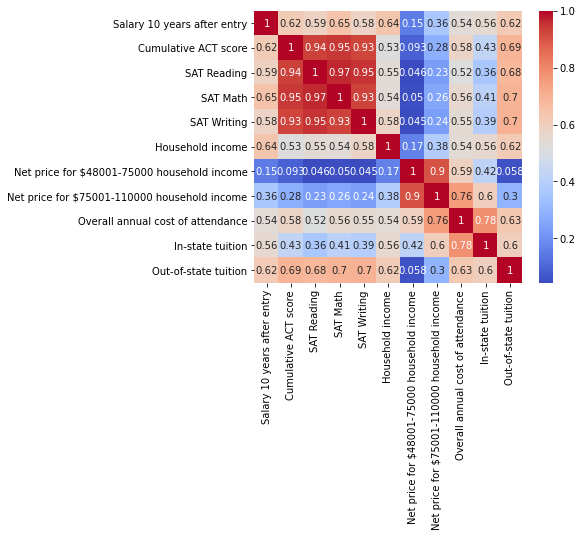

In [54]:
#feature selection
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split as tts
collegeInfoClean=collegeInfo.dropna()

#Correlation with output variable
cor_target = abs(cor["Overall annual cost of attendance"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
#display(relevant_features)

#also ensure that the features aren't highly correlated with each other
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(6,5))
cor = collegeInfoClean[relevant_features.index].corr() #just do collegeInfoClean.corr() to see all features
sns.heatmap(cor, annot=True, cmap="coolwarm")
plt.show() #if 2 features have a correlation of 0.7 or more, remove 1 of them
#the 2 net prices based on hh income are highly correlated with each other - drop Net price for $75001-110000 household income
#the 3 SATs and ACT are all obviously highly correlated with each other - only leave ACT
relevant_features.drop(['Net price for $75001-110000 household income','SAT Math','SAT Writing','SAT Reading'],inplace=True)

#Other feature selection methods: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
#display(relevant_features) #after removing so many useless features, the score only went down by 3


In [55]:
#build the model
pd.options.mode.chained_assignment = None #avoid the false warnings
y = collegeInfoClean['Overall annual cost of attendance']
X = collegeInfoClean[relevant_features.index].drop('Overall annual cost of attendance',axis=1)
X_train, X_test, y_train, y_test = tts(X,y)
model = LinearRegression(normalize=True)
model.fit(X_train, y_train)

prediction = model.predict(X.loc['University of Illinois at Urbana-Champaign'].values.reshape(1,-1))
trueCost = collegeInfoClean.loc['University of Illinois at Urbana-Champaign']['Overall annual cost of attendance']
print('UIUC prediction:',prediction[0],'UIUC true:',trueCost)

imaginaryUni = pd.DataFrame({'Salary 10 years after entry': 100000,
                         'Cumulative ACT score':10,
                         'Houshold income':20000,
                         'Net price for $48001-75000 household income':50000,
                         'In-state tuition':20000,
                         'Out-of-state tuition':80000},index=['Imaginary University'])
print('Imaginary uni prediction:',model.predict(imaginaryUni.values.reshape(1,-1))[0])

X_test['Predicted Cost'] = model.predict(X_test)
X_test['Actual cost'] = pd.merge(X_test,y,how='left',left_index=True,right_index=True)['Overall annual cost of attendance']
X_test

UIUC prediction: 29416.769346242683 UIUC true: 30082.0
Imaginary uni prediction: 46828.793386390884


,Salary 10 years after entry,Cumulative ACT score,Household income,Net price for $48001-75000 household income,In-state tuition,Out-of-state tuition,Predicted Cost,Actual cost
Name,,,,,,,,
Ohio University-Main Campus,40500.0,24.0,59563.0,22466.0,12192.0,21656.0,27904.578032,27705.0
Indiana University-Kokomo,36200.0,21.0,60071.0,10651.0,7344.0,19400.0,17945.357736,15444.0
University of Michigan-Ann Arbor,63400.0,32.0,77145.0,10956.0,15262.0,49350.0,29866.340591,29407.0
East Stroudsburg University of Pennsylvania,44600.0,22.0,69357.0,17739.0,11502.0,24184.0,24643.161289,21851.0
Pennsylvania State University-Penn State Mont Alto,50100.0,25.0,63381.0,19591.0,13702.0,21886.0,27546.383447,27014.0
...,...,...,...,...,...,...,...,...
University of Connecticut,58400.0,29.0,80999.0,18218.0,15730.0,38098.0,31313.669082,30687.0
The University of Virginia's College at Wise,38400.0,22.0,48782.0,10376.0,10119.0,27846.0,20934.876781,21789.0
State University of New York at New Paltz,45000.0,27.0,72171.0,18197.0,8254.0,18034.0,23827.571408,24842.0
